# Motion planning example
This jupyter notebook was used to run the motion planning example, and used to produce the plots. We set up the problem as an unconstrained optimization problem and apply gradient descent. 

Scroll to the bottom to run the code that generates the plots used in the paper.

In [1]:
%matplotlib inline
import sys
sys.path.append('../../src')

from scripts.utils import maybe_makedirs
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
#### Settings ####
save_fig = False
fig_dir = "figs/motion_planning"
data_dir = "data/motion_planning"

# Single integrator dynamics


In [4]:
obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()     # red box in bottom right corner
obs_2 = torch.tensor([.2, 0.7, 0.8, 1.2]).float()        # green box in top right corner
obs_3 = torch.tensor([0.0, 0.0, 0.4]).float()            # blue circle in the center
obs_4 = torch.tensor([-1.0, -0.7, -0.2, 0.5]).float()    # orange box on the left

### Plot configuration

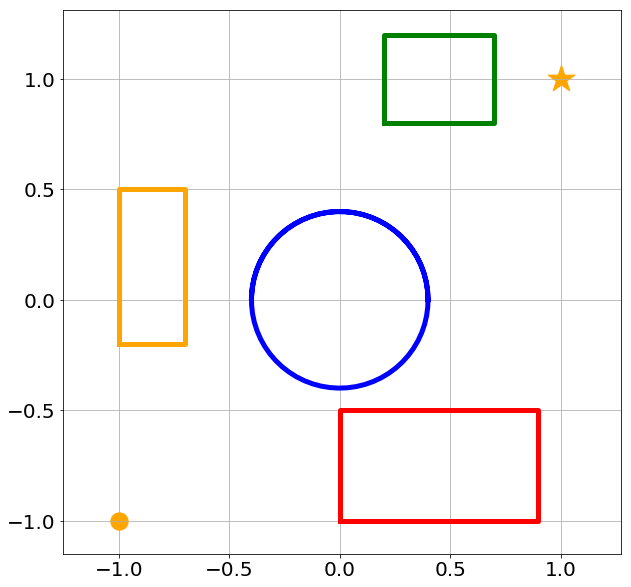

In [5]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

plt.scatter([-1], [-1], s=300, c="orange")
plt.scatter([1], [1], s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()

if save_fig:
    plt.savefig(fig_dir + "/configuration.png")

### functions that construct STL formulas

In [6]:
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression(obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression(obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression(obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
#     ϕ1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box, interval=[0,3]), interval=[0, 12])

def always_stay_outside_circle(xy, obs):
    d1 = stlcg.Expression('d1', torch.norm(xy - obs[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0))
    r1 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(d1 > r1)), d1

def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression(u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

### initializing solution $z$ as a straight line

In [23]:
dx = 0.04
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = -np.ones(2)
xf = np.ones(2)
N = n.shape

u_max = torch.as_tensor(0.8).float()       # u max

### Setting up linear dynamics matrices

$x_{t+1} = Ax_t + Bu_t$, wher $A = I$, and $B = \Delta t\cdot I$. 

$Z = (x,u)$ (i.e., concatenating $x$ and $u$

$E$ represents a massive matrix that computes $Ax_t+ Bu_t - x_{t+1}$ and $d$ represents what it should equal to.

The last 4 rows of $E$ and last 4 elements of $d$ correspond to the end point constraints.

Slightly convoluted way to get a initial straight line guess. but oh well

In [24]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


### Constructing  $\phi_1 = \lozenge\,\square_{[0,5]} \text{inside red box} \: \wedge \: \lozenge \, \square_{[0, 5]} \text{inside green box} \: \wedge \: \neg \square \, \text{inside blue circle}$ 


In [31]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

use_integral = False
margin = 0.05 # can add a margin so things are not right on the boundary


In [32]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 5
inside_box_1, _ = inside_box(X, obs_1)
inside_box_2, _ = inside_box(X, obs_2)

if use_integral:
    ##################### using integral operator #########################
    print("Using integral operator")
    has_been_inside_box_1 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_1, interval=[0,T]))
    has_been_inside_box_2 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_2, interval=[0,T]))
    fig_path = fig_dir + "/phi_1_integral_margin=" + str(margin)
    maybe_makedirs(fig_path)

    data_path = data_dir + "/phi_1_integral_margin=" + str(margin)
    maybe_makedirs(data_path)

else:
    ##################### using always operator #########################
    print("Using always operator")
    has_been_inside_box_1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_1, interval=[0,T]))
    has_been_inside_box_2 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_2, interval=[0,T]))

    fig_path = fig_dir + "/phi_1_integral_margin=" + str(margin)
    maybe_makedirs(fig_path)

    data_path = data_dir + "/phi_1_integral_margin=" + str(margin)
    maybe_makedirs(data_path)

always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ1 = (has_been_inside_box_1 & has_been_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ1.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

Using always operator


## Do the gradient steps here, or you can proceed to the end of the notebook to plot the results from a saved data file.

In [33]:
##### hyperparameters #####
γ = 0.3
lr = 0.05
keepdim = True
###########################
if use_integral:
    print("Using integral operator")
else:
    print("Using always operator")

for _ in range(5000):
#     optimizer.zero_grad()
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    

    if use_integral:
        robustness_box = torch.relu(-(ϕ1.subformula1.robustness((box_inputs, box_inputs), scale=-1, keepdim=keepdim, padding_type="same", custom_number=0.1).squeeze() - margin/Δt) )
    else:
        robustness_box = torch.relu(-(ϕ1.subformula1.robustness((box_inputs, box_inputs), scale=-1, keepdim=keepdim).squeeze() - margin) )

    robustness_circle = torch.relu(-(ϕ1.subformula2.robustness(circle_inputs, scale=-1, keepdim=keepdim).squeeze() - margin) )
    robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())

    robustness = robustness_box + robustness_circle + robustness_2

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue")
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_box: %.3f     robustness_circle: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_box.detach().numpy(), robustness_circle.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

Using always operator
0: loss: 0.248   robustness_box: 0.407     robustness_circle: 0.421     robustness_2: 0.000     cont: 0.000000
100: loss: 0.179   robustness_box: 0.260     robustness_circle: 0.277     robustness_2: 0.000     cont: 0.018515
200: loss: 0.124   robustness_box: 0.189     robustness_circle: 0.148     robustness_2: 0.000     cont: 0.022944
300: loss: 0.087   robustness_box: 0.146     robustness_circle: 0.053     robustness_2: 0.000     cont: 0.026896


KeyboardInterrupt: 

## Plotting results

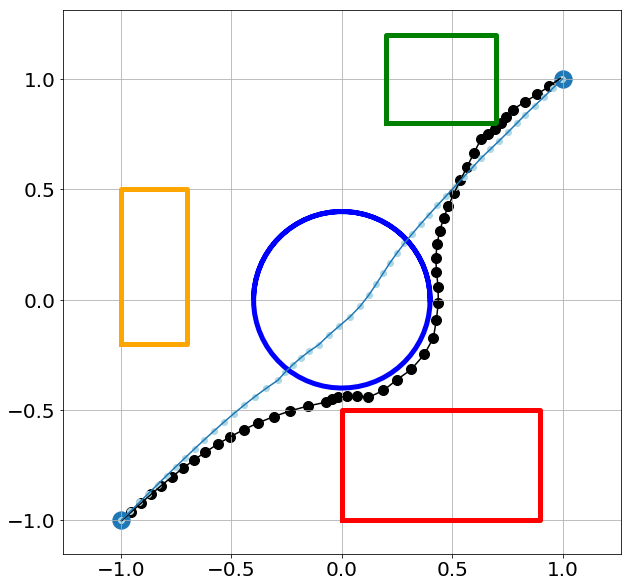

In [34]:
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
# plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.axis("equal")


xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

In [13]:
data_path

'data/motion_planning/phi_1_integral_margin=0.05'

## Save data

In [14]:
np.save(data_path + "/X.npy", X.detach().numpy())
np.save(data_path + "/U.npy", U.detach().numpy())

### Constructing  $\phi_2 = \lozenge\,\square_{[0,5]} \text{inside orange box} \: \wedge \: \neg \square \text{inside green box} \: \wedge \: \neg \square \, \text{inside blue circle}$ 

In [35]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


use_integral = False
margin = 0.05 # can add a margin so things are not right on the boundary


In [36]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 5
inside_box_4, _ = inside_box(X, obs_4)
inside_box_2, _ = inside_box(X, obs_2)

if use_integral:
    ##################### using integral operator #########################
    print("Using integral operator")
    has_been_inside_box_4 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_4, interval=[0,T]))
    never_inside_box_2 = ~stlcg.Integral1d(subformula=inside_box_2, interval=[0,T])
    fig_path = fig_dir + "/phi_2_integral_margin=" + str(margin)
    maybe_makedirs(fig_path)

    data_path = data_dir + "/phi_2_integral_margin=" + str(margin)
    maybe_makedirs(data_path)
    ########################################################################
else:
    ##################### using always operator #########################
    print("Using always operator")
    has_been_inside_box_4 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_4, interval=[0,T]))
    never_inside_box_2 = ~stlcg.Always(subformula=inside_box_2, interval=[0,T])
    fig_path = fig_dir + "/phi_2_margin=" + str(margin)
    maybe_makedirs(fig_path)

    data_path = data_dir + "/phi_2_margin=" + str(margin)
    maybe_makedirs(data_path)
    ########################################################################


always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ2 = (has_been_inside_box_4 & never_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ2.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

Using always operator


In [37]:
##### hyperparameters #####
γ = 0.3
lr = 0.05
keepdim = True
###########################
if use_integral:
    print("Using integral operator")
else:
    print("Using always operator")

for _ in range(5000):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y))
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    if use_integral:    
        robustness_box = torch.relu(-(ϕ2.subformula1.robustness((box_inputs, box_inputs), scale=-1, keepdim=keepdim, padding_type="same", custom_number=0.1).squeeze() - margin/Δt) )
    else:
        robustness_box = torch.relu(-(ϕ2.subformula1.robustness((box_inputs, box_inputs), scale=-1, keepdim=keepdim, padding_type="same", custom_number=0.1).squeeze() - margin) )
        
    robustness_circle = torch.relu(-(ϕ2.subformula2.robustness(circle_inputs, scale=-1, keepdim=keepdim).squeeze() - margin) )
    robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())
    robustness = robustness_box + robustness_circle + robustness_2


    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1], c="orange")
        plt.scatter(xs[:,0], xs[:,1], c="orange")
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_box: %.3f     robustness_circle: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_box.detach().numpy(), robustness_circle.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

Using always operator
0: loss: 0.247   robustness_box: 0.403     robustness_circle: 0.421     robustness_2: 0.000     cont: 0.000000
100: loss: 0.212   robustness_box: 0.268     robustness_circle: 0.386     robustness_2: 0.000     cont: 0.015810


KeyboardInterrupt: 

## plotting results

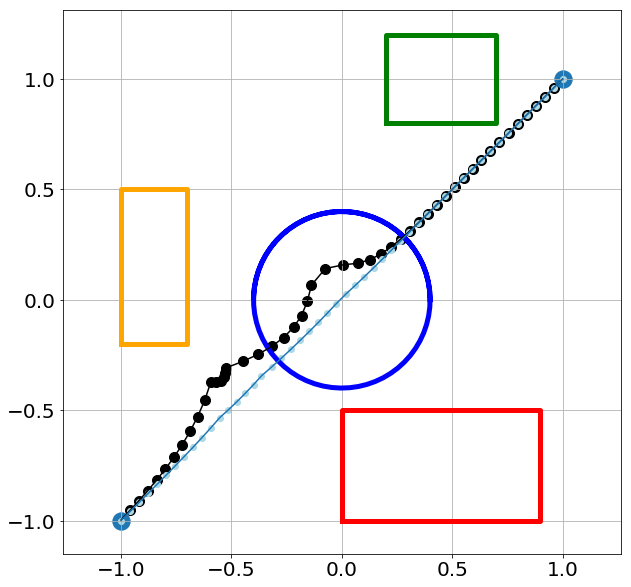

In [38]:
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.axis("equal")


xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

In [41]:
data_path

'data/motion_planning/phi_2_margin=0.05'

## Save data

In [163]:
np.save(data_path + "/X.npy", X.detach().numpy())
np.save(data_path + "/U.npy", U.detach().numpy())

# Plotting combined plot (always operator)

In [3]:

obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()
obs_2 = torch.tensor([.2, 0.7, 0.8, 1.2]).float()
obs_3 = torch.tensor([0.0, 0.0, 0.4]).float()
obs_4 = torch.tensor([-1.0, -0.7, -0.2, 0.5]).float()

x0 = -np.ones(2)
xf = np.ones(2)
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
u_max = torch.as_tensor(0.8).float()

Text(0, 0.5, 'y')

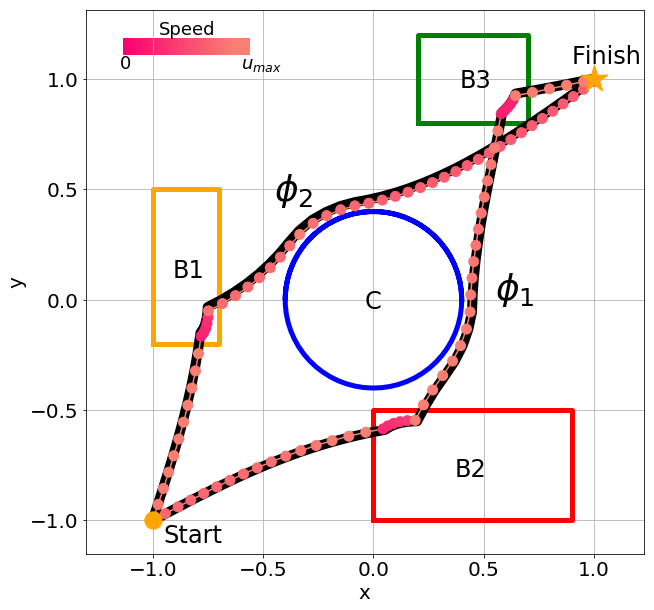

In [6]:
linewidth = 10
markersize = 100
margin = 0.05

plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)



u = np.load("data/motion_planning/phi_2_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

xy = np.load("data/motion_planning/phi_2_margin=" + str(margin) + "/X.npy")
u = np.load("data/motion_planning/phi_2_margin=" + str(margin) + "/U.npy")

plt.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)

xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1], c="SALMON")
plt.scatter(xs[:,0], xs[:,1], s=markersize, marker='o', color=colors, zorder=10)


u = np.load("data/motion_planning/phi_1_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

xy = np.load("data/motion_planning/phi_1_margin=" + str(margin) + "/X.npy")
u = np.load("data/motion_planning/phi_1_margin=" + str(margin) + "/U.npy")

plt.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)

xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1], c="salmon")
plt.scatter(xs[:,0], xs[:,1], s=markersize, marker='o', color=colors, zorder=10)


plt.axis("equal")
plt.scatter([-1], [-1], s=300, c="orange", zorder=10)
plt.scatter([1], [1], s=800, marker='*', c="orange", zorder=10)
plt.text(-0.95, -1.1, "Start", fontsize=24)
plt.text(0.9, 1.07, "Finish", fontsize=24)

plt.text(0.55, 0.0, "$\phi_1$", fontsize=36)
plt.text(-0.45, 0.45, "$\phi_2$", fontsize=36)
plt.text(-0.97, 1.2, "Speed", fontsize=18)
plt.text(-1.15, 1.05, "0", fontsize=18)
plt.text(-0.6, 1.05, "$u_{max}$", fontsize=18)

plt.text(-0.91, 0.1, "B1", fontsize=24)
plt.text(0.37, -0.8, "B2", fontsize=24)
plt.text(0.39, 0.96, "B3", fontsize=24)
plt.text(-0.04, -0.04, "C", fontsize=24)


colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* np.arange(50)/49
plt.scatter(np.arange(50)/49/2 - 1.1, 1.15*np.ones(50), color=colors, s=250, marker='s')

plt.grid()
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
# plt.savefig("figs/motion_planning/phi_margin=0.05.png")

# Plotting combined plot (integral operator)

Text(0, 0.5, 'y')

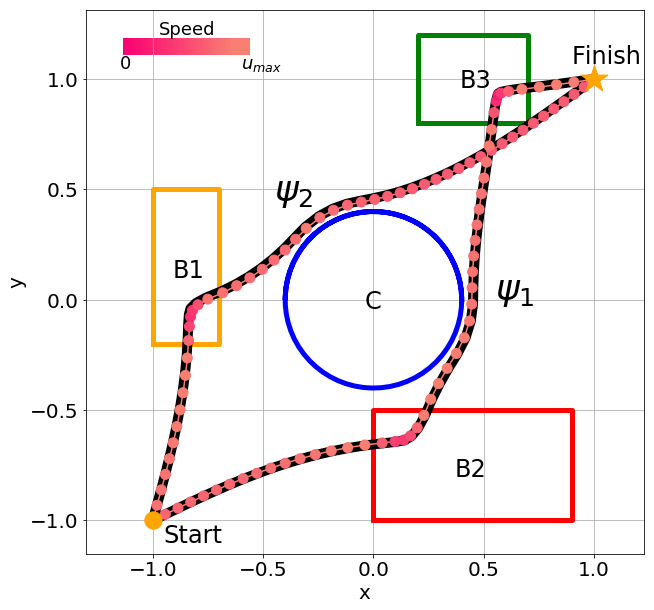

In [5]:
linewidth = 10
markersize = 100
margin = 0.05

plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)



u = np.load("data/motion_planning/phi_2_integral_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

xy = np.load("data/motion_planning/phi_2_integral_margin=" + str(margin) + "/X.npy")
u = np.load("data/motion_planning/phi_2_integral_margin=" + str(margin) + "/U.npy")

plt.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)

xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1], c="SALMON")
plt.scatter(xs[:,0], xs[:,1], s=markersize, marker='o', color=colors, zorder=10)


u = np.load("data/motion_planning/phi_1_integral_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

xy = np.load("data/motion_planning/phi_1_integral_margin=" + str(margin) + "/X.npy")
u = np.load("data/motion_planning/phi_1_integral_margin=" + str(margin) + "/U.npy")

plt.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)

xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1], c="salmon")
plt.scatter(xs[:,0], xs[:,1], s=markersize, marker='o', color=colors, zorder=10)


plt.axis("equal")
plt.scatter([-1], [-1], s=300, c="orange", zorder=10)
plt.scatter([1], [1], s=800, marker='*', c="orange", zorder=10)
plt.text(-0.95, -1.1, "Start", fontsize=24)
plt.text(0.9, 1.07, "Finish", fontsize=24)

plt.text(0.55, 0.0, "$\psi_1$", fontsize=36)
plt.text(-0.45, 0.45, "$\psi_2$", fontsize=36)
plt.text(-0.97, 1.2, "Speed", fontsize=18)
plt.text(-1.15, 1.05, "0", fontsize=18)
plt.text(-0.6, 1.05, "$u_{max}$", fontsize=18)

plt.text(-0.91, 0.1, "B1", fontsize=24)
plt.text(0.37, -0.8, "B2", fontsize=24)
plt.text(0.39, 0.96, "B3", fontsize=24)
plt.text(-0.04, -0.04, "C", fontsize=24)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* np.arange(50)/49
plt.scatter(np.arange(50)/49/2 - 1.1, 1.15*np.ones(50), color=colors, s=250, marker='s')

plt.grid()
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
# plt.savefig("figs/motion_planning/phi_integral_margin=0.05.png")

### Plotting the control sequence (not included in the paper)

In [32]:
u = np.load("data/motion_planning/phi_2_integral_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha_integral = u_norm/u_max.numpy()

In [33]:
u = np.load("data/motion_planning/phi_2_margin=" + str(margin) + "/U.npy")
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

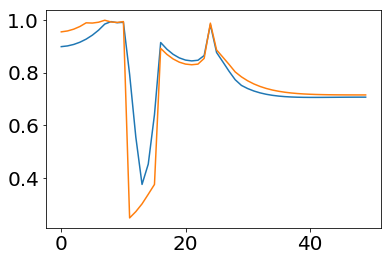

In [34]:
plt.plot(alpha_integral)
plt.plot(alpha)